In [16]:
import sys
sys.path.append("..")

import torch
from diffusers import StableDiffusion3Pipeline

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path

from utils.data import get_data
from transformers import TextStreamer

In [4]:
#load stable diffusion
pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", torch_dtype=torch.float16)
pipe = pipe.to("cuda")
#load llava
MODEL_NAME = "liuhaotian/llava-v1.6-34b"
temperature = 0.2
max_new_tokens = 512

model_name = get_model_name_from_path(MODEL_NAME)
tokenizer, model, image_processor, context_len = load_pretrained_model(MODEL_NAME, model_base=None, model_name=model_name, load_8bit=True, load_4bit=False)

Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

text_encoder_3/config.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

(…)t_encoder_3/model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

tokenizer_3/special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

tokenizer_3/tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_3/tokenizer_config.json:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

transformer/config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/739 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/4.17G [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/247M [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.53G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [67]:
def run_stable_diffusion(desc):
    image = pipe(
        desc,
        negative_prompt="",
        num_inference_steps=28,
        guidance_scale=9.0,
    ).images[0]
    return image

In [68]:
def run_llava(image):
    if "llama-2" in model_name.lower():
        conv_mode = "llava_llama_2"
    elif "mistral" in model_name.lower():
        conv_mode = "mistral_instruct"
    elif "v1.6-34b" in model_name.lower():
        conv_mode = "chatml_direct"
    elif "v1" in model_name.lower():
        conv_mode = "llava_v1"
    elif "mpt" in model_name.lower():
        conv_mode = "mpt"
    else:
        conv_mode = "llava_v0"

    conv = conv_templates[conv_mode].copy()
    if "mpt" in model_name.lower():
        roles = ('user', 'assistant')
    else:
        roles = conv.roles

    image_size = image.size
    # Similar operation in model_worker.py
    image_tensor = process_images([image], image_processor, model.config)
    if type(image_tensor) is list:
        image_tensor = [image.to(model.device, dtype=torch.float16) for image in image_tensor]
    else:
        image_tensor = image_tensor.to(model.device, dtype=torch.float16)

    inp = "Provide a description of the image in one sentence. Add a description of the image in  <desc></desc> tags. Make up a caption for the given image to use in a news article in one sentence. Make up any details such as name, place, time etc. to make the caption seem real and believable. Enclose the caption in <caption></caption> tags."

    if image is not None:
        # first message
        if model.config.mm_use_im_start_end:
            inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
        else:
            inp = DEFAULT_IMAGE_TOKEN + '\n' + inp
        image = None

    conv.append_message(conv.roles[0], inp)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()

    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(model.device)
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    #streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=image_tensor,
            image_sizes=[image_size],
            do_sample=True if temperature > 0 else False,
            temperature=temperature,
            max_new_tokens=max_new_tokens,
            #streamer=streamer,
            use_cache=True)

    outputs = tokenizer.decode(output_ids[0]).strip()
    conv.messages[-1][-1] = outputs

    print("\n", {"prompt": prompt, "outputs": outputs}, "\n")
    output = {'desc':outputs[outputs.find('<desc>')+len('desc'):outputs.find('</desc>')], 'caption':outputs[outputs.find('<caption>')+len('<caption>'):outputs.find('</caption>')]}
    return output

In [69]:
image, caption, img_path, annotation = get_data(4)

In [51]:
output = run_llava(image)
desc, caption_ = output['desc'], output['caption']
image_ = run_stable_diffusion(desc)


 {'prompt': '<|im_start|>system\nAnswer the questions.<|im_end|><|im_start|>user\n<image>\nProvide a description of the image in one sentence. Add a description of the image in  <desc></desc> tags. Make up a caption for the given image to use in a news article in one sentence. Make up any details such as name, place, time etc. to make the caption seem real and believable. Enclose the caption in <caption></caption> tags.<|im_end|><|im_start|>assistant\n', 'outputs': 'The image shows a 3D rendering of a robot with a humanoid shape, featuring a black and gray color scheme with visible mechanical components and a head with a camera-like device. The robot has a torso, arms, and legs, and the word "THOR" is visible on its chest. The robot is standing upright against a plain white background.\n\n<desc>A 3D model of a robot named THOR.</desc>\n\n<caption>Robotic breakthrough: Virginia Tech unveils THOR, a humanoid robot capable of advanced tasks.</caption><|im_end|>'} 



  0%|          | 0/28 [00:00<?, ?it/s]

TRUE IMAGE: 


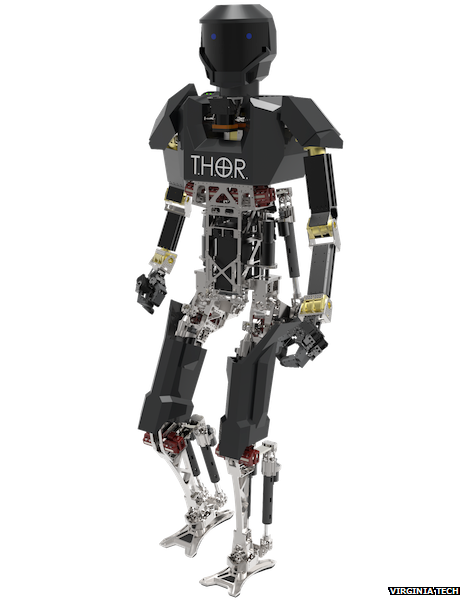

TRUE CAPTION:  Virginia Tech s Thor includes artificial elastic muscles It will not be ready until 2014 so will be replaced by a less advanced substitute at this stage
FALSE IMAGE: 


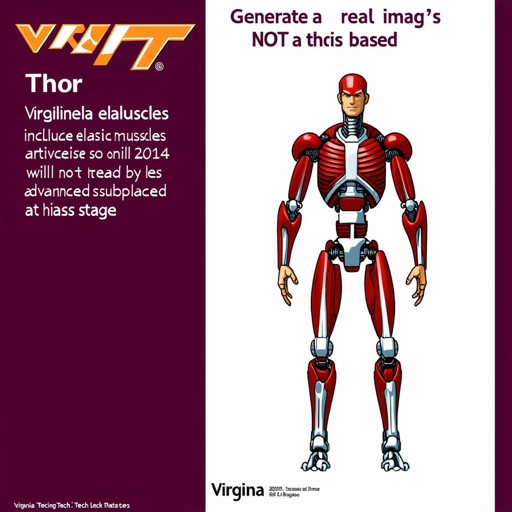

FALSE CAPTION:  Robotic breakthrough: Virginia Tech unveils THOR, a humanoid robot capable of advanced tasks.


In [58]:
print("TRUE IMAGE: ")
display(image)
print("TRUE CAPTION: ", caption)
print("FALSE IMAGE: ")
image_ = image_.resize((512, 512))
display(image_)
print("FALSE CAPTION: ", caption_)

In [70]:
import gradio as gr
import os
import time
from PIL import Image
import numpy as np

def store_files(image, text):
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    os.makedirs("stored_outputs", exist_ok=True)
    
    # Save image
    image.save(f"stored_outputs/image_{timestamp}.png")
    
    # Save text
    with open(f"stored_outputs/text_{timestamp}.txt", "w") as f:
        f.write(text)
    
    return "Files stored successfully!"

def process_inputs(image, text):
    output = run_llava(image)
    desc, processed_text = output['desc'], output['caption']
    processed_image = run_stable_diffusion(desc)
    processed_image = processed_image.resize((512, 512))
    return processed_image, processed_text

# Gradio interface
demo = gr.Blocks()

with demo:
    gr.Markdown("# Image and Text Processor")
    
    with gr.Row():
        image_input = gr.Image(type='pil')
        text_input = gr.Textbox(label="Input Text")
    
    process_btn = gr.Button("Process")
    
    with gr.Row():
        image_output = gr.Image(label="Processed Image", type='pil')
        text_output = gr.Textbox(label="Processed Text")
    
    store_btn = gr.Button("Store Outputs")
    store_output = gr.Textbox(label="Storage Status")
    
    process_btn.click(
        process_inputs,
        inputs=[image_input, text_input],
        outputs=[image_output, text_output]
    )
    
    store_btn.click(
        store_files,
        inputs=[image_output, text_output],
        outputs=[store_output]
    )

# Launch the interface
demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7866


Running on public URL: https://3050ec952c0970767b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)



 {'prompt': '<|im_start|>system\nAnswer the questions.<|im_end|><|im_start|>user\n<image>\nProvide a description of the image in one sentence. Add a description of the image in  <desc></desc> tags. Make up a caption for the given image to use in a news article in one sentence. Make up any details such as name, place, time etc. to make the caption seem real and believable. Enclose the caption in <caption></caption> tags.<|im_end|><|im_start|>assistant\n', 'outputs': 'The image shows a person sitting on a chair with their legs crossed, wearing a black suit and gloves, against a gradient background that transitions from orange to yellow. The person is looking to the side with their hand on their chin, giving an impression of contemplation or deep thought. The overall style of the image is modern and artistic, with a focus on the individual\'s pose and attire.\n\n<desc>A person in a black suit sitting on a chair with a gradient background.</desc>\n\n<caption>Actor John Smith poses for a p

  0%|          | 0/28 [00:00<?, ?it/s]